In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt


In [2]:
#Extracting DataFrame From Web :
import pandas_datareader as web

c:\python38\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [3]:
#Stock Symbol Used : Alphabet A Inc - > Google 
# From 1 April 2020 to 30 June 2020
#This data is full collection of all stock features from Google's Stock Market
df_g=web.DataReader('GOOGL',data_source='yahoo',start='04-15-2007',end='06-01-2020')

In [4]:
df_g.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3306 entries, 2007-04-16 to 2020-06-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       3306 non-null   float64
 1   Low        3306 non-null   float64
 2   Open       3306 non-null   float64
 3   Close      3306 non-null   float64
 4   Volume     3306 non-null   float64
 5   Adj Close  3306 non-null   float64
dtypes: float64(6)
memory usage: 180.8 KB


In [5]:
df_g.describe()

High          Low         Open        Close        Volume  \
count  3306.000000  3306.000000  3306.000000  3306.000000  3.306000e+03   
mean    593.745580   582.666703   588.391406   588.381232  4.742852e+06   
std     362.146388   355.766541   358.944104   359.188099  4.407584e+06   
min     134.819824   123.773773   131.386383   128.848846  5.206000e+05   
25%     285.228973   280.282776   282.533783   282.558807  1.717450e+06   
50%     509.884888   502.506500   505.070068   506.303802  3.445800e+06   
75%     843.932495   836.242493   840.722488   840.517502  6.035300e+06   
max    1530.739990  1520.979980  1527.199951  1524.869995  4.652800e+07   

         Adj Close  
count  3306.000000  
mean    588.381232  
std     359.188099  
min     128.848846  
25%     282.558807  
50%     506.303802  
75%     840.517502  
max    1524.869995

In [6]:

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [7]:
df_g
#Indicating Number Of days and features -> 123 days and 6 stock features

High          Low         Open        Close      Volume  \
Date                                                                         
2007-04-16   238.733734   234.309311   234.464462   237.372375  10145600.0   
2007-04-17   238.433426   236.036041   237.137131   236.636642   6413700.0   
2007-04-18   240.190186   235.000000   235.865860   238.243240  11329600.0   
2007-04-19   241.216217   235.030029   237.487488   236.061066  21997100.0   
2007-04-20   246.496490   241.251251   245.505508   241.481476  24298600.0   
...                 ...          ...          ...          ...         ...   
2020-05-26  1445.109985  1419.400024  1441.959961  1421.369995   2229500.0   
2020-05-27  1425.349976  1394.599976  1420.000000  1420.280029   1584200.0   
2020-05-28  1444.459961  1399.079956  1400.000000  1418.239990   1758500.0   
2020-05-29  1436.729980  1415.979980  1420.430054  1433.520020   1852200.0   
2020-06-01  1441.579956  1422.280029  1425.699951  1434.869995   1258100.0   

              Adj Close  
Date                     
2007-04-16   237.372375  
2007-04-17   236.636642  
2007-04-18   238.243240  
2007-04-19   236.061066  
2007-04-20   241.481476  
...                 ...  
2020-05-26  1421.369995  
2020-05-27  1420.280029  
2020-05-28  1418.239990  
2020-05-29  1433.520020  
2020-06-01  1434.869995  

[3306 rows x 6 columns]

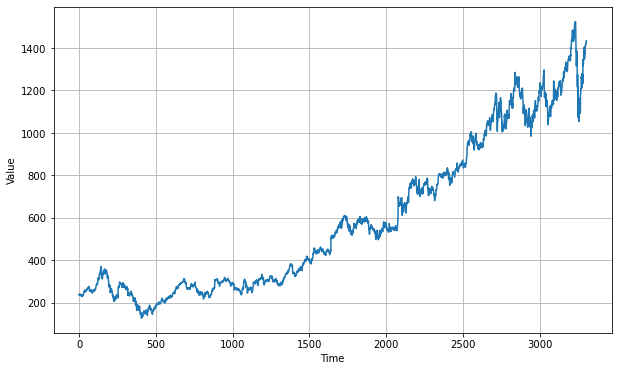

In [8]:

temps=[]
time_step=[]

step=0
for row in range(len(df_g)):
      time_step.append(step)
      step = step + 1

ds = np.array(df_g['Close'].values)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, ds)



In [9]:
ds_g = ds.reshape(-1,1)
print(ds_g.shape)

(3306, 1)


In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
series = scaler.fit_transform(ds_g)

In [72]:
3306*0.85

2810.1

In [73]:
split_time = 2900
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [74]:
time_train.shape,x_train.shape

((2900,), (2900, 1))

In [75]:
time_valid.shape,x_valid.shape

((406,), (406, 1))

In [76]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [77]:
def windowed_valid_dataset(series, window_size, batch_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [78]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [79]:
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [80]:
print(train_set)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>


In [81]:
#Checking The Batches And their corresponding or respective label ,x and y 
for x,y in train_set:
    print("x :",x.numpy())
    print("y :",y.numpy())

x : [[[0.1143103 ]
  [0.11474409]
  [0.11444294]
  [0.11313075]
  [0.11204444]
  [0.1164865 ]
  [0.1167518 ]
  [0.11770189]
  [0.11555793]
  [0.11671953]
  [0.11918256]
  [0.11833646]
  [0.11770189]
  [0.11744016]
  [0.11788473]
  [0.11817154]
  [0.11887783]
  [0.11976696]
  [0.11941201]
  [0.1212835 ]
  [0.12035491]
  [0.12201128]
  [0.12064174]
  [0.12153087]
  [0.12234113]
  [0.12321592]
  [0.12700187]
  [0.12943981]
  [0.13101369]
  [0.12976964]]

 [[0.11186519]
  [0.10932687]
  [0.10854529]
  [0.10360849]
  [0.10317109]
  [0.1021278 ]
  [0.10524693]
  [0.09729497]
  [0.09702607]
  [0.09643452]
  [0.09941381]
  [0.0966568 ]
  [0.10022765]
  [0.10270503]
  [0.10651249]
  [0.10185892]
  [0.10150756]
  [0.0990804 ]
  [0.09471363]
  [0.09273102]
  [0.09972572]
  [0.09895133]
  [0.08026529]
  [0.07577663]
  [0.07875593]
  [0.0830976 ]
  [0.07822174]
  [0.08408711]
  [0.07875952]
  [0.08090705]]

 [[0.11446445]
  [0.1120552 ]
  [0.11190104]
  [0.10743389]
  [0.10896119]
  [0.10885363]
  

y : [[[0.0366586 ]]

 [[0.12676526]]

 [[0.10248633]]

 [[0.10638343]]

 [[0.13652774]]

 [[0.09830599]]

 [[0.1177234 ]]

 [[0.09991216]]

 [[0.09160167]]

 [[0.11108003]]

 [[0.10244329]]

 [[0.12626332]]

 [[0.12323384]]

 [[0.11475126]]

 [[0.0900457 ]]

 [[0.11241015]]

 [[0.12135162]]

 [[0.06539392]]

 [[0.08981984]]

 [[0.10363   ]]

 [[0.04662902]]

 [[0.09596127]]

 [[0.08966208]]

 [[0.12240566]]

 [[0.09224343]]

 [[0.07575154]]

 [[0.02642287]]

 [[0.10295957]]

 [[0.13795463]]

 [[0.09471363]]

 [[0.08922828]]

 [[0.13359862]]]
x : [[[0.09927758]
  [0.0977216 ]
  [0.09999462]
  [0.10088733]
  [0.10180156]
  [0.10248633]
  [0.10163664]
  [0.12333422]
  [0.12916374]
  [0.12562156]
  [0.12567534]
  [0.12711301]
  [0.12730661]
  [0.12872994]
  [0.12948283]
  [0.12871918]
  [0.12947566]
  [0.12772609]
  [0.12819215]
  [0.12840726]
  [0.13004928]
  [0.13151563]
  [0.13180602]
  [0.13241193]
  [0.13171281]
  [0.13101728]
  [0.12897731]
  [0.12399391]
  [0.12119027]
  [0.11697768

x : [[[0.03401631]
  [0.02934481]
  [0.02583132]
  [0.03990678]
  [0.0360527 ]
  [0.0366586 ]
  [0.03654029]
  [0.03192614]
  [0.03925786]
  [0.03040244]
  [0.02645155]
  [0.02642287]
  [0.02199157]
  [0.01936721]
  [0.01203191]
  [0.0195895 ]
  [0.01885094]
  [0.0153016 ]
  [0.0143336 ]
  [0.00815273]
  [0.00076006]
  [0.00178901]
  [0.        ]
  [0.00882316]
  [0.0124227 ]
  [0.01273461]
  [0.00306534]
  [0.00633503]
  [0.00788384]
  [0.00605898]]

 [[0.03270771]
  [0.03078964]
  [0.02907233]
  [0.02980371]
  [0.02976069]
  [0.03067492]
  [0.03451824]
  [0.04081383]
  [0.04349914]
  [0.03623554]
  [0.03606704]
  [0.03786323]
  [0.03593797]
  [0.03055301]
  [0.03429954]
  [0.03054584]
  [0.0319118 ]
  [0.02603567]
  [0.03155329]
  [0.03018733]
  [0.02858833]
  [0.02887873]
  [0.02499597]
  [0.02439366]
  [0.02204176]
  [0.01728063]
  [0.01833109]
  [0.01199247]
  [0.01818769]
  [0.02167967]]

 [[0.10360849]
  [0.10317109]
  [0.1021278 ]
  [0.10524693]
  [0.09729497]
  [0.09702607]
  

x : [[[0.09738101]
  [0.09742762]
  [0.09843506]
  [0.09617637]
  [0.09793312]
  [0.08924621]
  [0.09046158]
  [0.0864856 ]
  [0.084503  ]
  [0.09472438]
  [0.09020704]
  [0.08889486]
  [0.09086313]
  [0.08966208]
  [0.08981984]
  [0.08637805]
  [0.08496549]
  [0.07800304]
  [0.07694182]
  [0.07877386]
  [0.07874159]
  [0.07816796]
  [0.08354217]
  [0.08181052]
  [0.08064174]
  [0.08458546]
  [0.08897015]
  [0.08650353]
  [0.08177108]
  [0.08150577]]

 [[0.11737204]
  [0.12191806]
  [0.12143049]
  [0.12580084]
  [0.12723849]
  [0.12315497]
  [0.12105045]
  [0.12580801]
  [0.12747511]
  [0.12875145]
  [0.12692659]
  [0.12312629]
  [0.12097874]
  [0.115981  ]
  [0.11564398]
  [0.11209822]
  [0.10954914]
  [0.11858027]
  [0.11669443]
  [0.12259567]
  [0.12775118]
  [0.13011381]
  [0.1320104 ]
  [0.13133638]
  [0.13120014]
  [0.12856861]
  [0.13264496]
  [0.13191716]
  [0.13200323]
  [0.1292928 ]]

 [[0.11475485]
  [0.11529981]
  [0.1034615 ]
  [0.11328135]
  [0.10453347]
  [0.10923724]
  

y : [[[0.10176929]]

 [[0.06691404]]

 [[0.12995248]]

 [[0.0195895 ]]

 [[0.29526138]]

 [[0.11474409]]

 [[0.09204624]]

 [[0.30808355]]

 [[0.10141076]]

 [[0.12916374]]

 [[0.12312629]]

 [[0.30212375]]

 [[0.23175762]]

 [[0.11015146]]

 [[0.04607331]]

 [[0.31127119]]

 [[0.31724529]]

 [[0.2214215 ]]

 [[0.03155329]]

 [[0.23216274]]

 [[0.22220666]]

 [[0.29258235]]

 [[0.29126823]]

 [[0.17047591]]

 [[0.31652897]]

 [[0.06512145]]

 [[0.02746975]]

 [[0.12143049]]

 [[0.12673658]]

 [[0.12620596]]

 [[0.11034147]]

 [[0.0579188 ]]]
x : [[[0.33636391]
  [0.32692997]
  [0.32882824]
  [0.32876375]
  [0.32919353]
  [0.32290425]
  [0.32379965]
  [0.32764629]
  [0.32874229]
  [0.31894297]
  [0.32584832]
  [0.31658629]
  [0.30539735]
  [0.29791895]
  [0.30074126]
  [0.29503932]
  [0.29231014]
  [0.28231745]
  [0.28905806]
  [0.29310529]
  [0.29644333]
  [0.30429423]
  [0.3008917 ]
  [0.30159368]
  [0.30808355]
  [0.30773256]
  [0.30903627]
  [0.3144803 ]
  [0.3115434 ]
  [0.31184424

x : [[[0.117623  ]
  [0.11597741]
  [0.11187594]
  [0.11137759]
  [0.11563681]
  [0.1148158 ]
  [0.11568341]
  [0.11594156]
  [0.11747601]
  [0.12149861]
  [0.12607331]
  [0.12524154]
  [0.12634578]
  [0.126923  ]
  [0.12493322]
  [0.1271883 ]
  [0.12631351]
  [0.12480772]
  [0.12515192]
  [0.12447789]
  [0.12783364]
  [0.125661  ]
  [0.12500493]
  [0.1263637 ]
  [0.12615218]
  [0.12940755]
  [0.12935735]
  [0.13084519]
  [0.13043291]
  [0.12792327]]

 [[0.30828358]
  [0.31600607]
  [0.31685574]
  [0.31291562]
  [0.31289411]
  [0.31031279]
  [0.31978486]
  [0.31950522]
  [0.32222994]
  [0.32018997]
  [0.32491169]
  [0.32538492]
  [0.32362101]
  [0.31061752]
  [0.30251497]
  [0.31032354]
  [0.30455498]
  [0.31476199]
  [0.3311033 ]
  [0.31405931]
  [0.31575511]
  [0.31756205]
  [0.32357081]
  [0.32983775]
  [0.32822083]
  [0.33440527]
  [0.33315406]
  [0.33789008]
  [0.3389298 ]
  [0.34182661]]

 [[0.1309635 ]
  [0.12997758]
  [0.13240476]
  [0.13141525]
  [0.12577575]
  [0.12069911]
  

  [0.50154768]]]
y : [[[0.47991476]]

 [[0.02401363]]

 [[0.1006794 ]]

 [[0.11619252]]

 [[0.49008654]]

 [[0.11859461]]

 [[0.31351328]]

 [[0.22333243]]

 [[0.07947656]]

 [[0.32357081]]

 [[0.48282303]]

 [[0.44725048]]

 [[0.21439096]]

 [[0.48919114]]

 [[0.33554017]]

 [[0.07197275]]

 [[0.20576856]]

 [[0.13799765]]

 [[0.29854215]]

 [[0.46803814]]

 [[0.50292301]]

 [[0.01637358]]

 [[0.05455588]]

 [[0.43740823]]

 [[0.27196915]]

 [[0.43294556]]

 [[0.33400373]]

 [[0.46348235]]

 [[0.46369723]]

 [[0.11917539]]

 [[0.49624689]]

 [[0.49821677]]]
x : [[[0.30063379]
  [0.30070545]
  [0.29435885]
  [0.29526138]
  [0.29703789]
  [0.28931592]
  [0.29776138]
  [0.29660807]
  [0.30109225]
  [0.30702341]
  [0.31862779]
  [0.31322674]
  [0.31197317]
  [0.30983855]
  [0.30079858]
  [0.30251055]
  [0.30371401]
  [0.29669402]
  [0.29099213]
  [0.2959777 ]
  [0.30092751]
  [0.29865678]
  [0.29360668]
  [0.29415109]
  [0.30110659]
  [0.29916534]
  [0.29929427]
  [0.30116391]
  [0.303477

x : [[[0.29113541]
  [0.28782596]
  [0.28703085]
  [0.27980319]
  [0.27061995]
  [0.26955261]
  [0.27081335]
  [0.26637931]
  [0.26375757]
  [0.26715293]
  [0.27011134]
  [0.26873602]
  [0.27335628]
  [0.2729838 ]
  [0.28046937]
  [0.29258235]
  [0.29591326]
  [0.29216687]
  [0.28104242]
  [0.27476743]
  [0.27534048]
  [0.29276143]
  [0.28892912]
  [0.28971706]
  [0.28455954]
  [0.28723144]
  [0.29013254]
  [0.28683748]
  [0.29463101]
  [0.29308378]]

 [[0.34054314]
  [0.33400373]
  [0.32817422]
  [0.33509365]
  [0.34196284]
  [0.33765704]
  [0.33690776]
  [0.33184546]
  [0.32284304]
  [0.32312626]
  [0.31353589]
  [0.30719366]
  [0.30929816]
  [0.30727612]
  [0.31458274]
  [0.31465802]
  [0.31708055]
  [0.29827711]
  [0.29496771]
  [0.30705922]
  [0.31388574]
  [0.29930861]
  [0.29291187]
  [0.2982413 ]
  [0.30074843]
  [0.31163652]
  [0.29690896]
  [0.29406514]
  [0.29845619]
  [0.29273279]]

 [[0.46659833]
  [0.47058107]
  [0.47319567]
  [0.46348235]
  [0.45520884]
  [0.45530197]
  

x : [[[0.10792507]
  [0.11359684]
  [0.1203334 ]
  [0.11610648]
  [0.12098591]
  [0.11792417]
  [0.11528547]
  [0.11672311]
  [0.11320606]
  [0.11741506]
  [0.11671953]
  [0.11431747]
  [0.11600251]
  [0.11566907]
  [0.11475485]
  [0.11514206]
  [0.10488481]
  [0.1046948 ]
  [0.10295957]
  [0.10879627]
  [0.11142781]
  [0.11671953]
  [0.1177234 ]
  [0.11385138]
  [0.11109078]
  [0.1128547 ]
  [0.11790266]
  [0.11098323]
  [0.10770994]
  [0.10638343]]

 [[0.07714259]
  [0.07655104]
  [0.07632159]
  [0.07642197]
  [0.07830778]
  [0.07763019]
  [0.07775925]
  [0.08105404]
  [0.08234112]
  [0.08646051]
  [0.08621314]
  [0.08710585]
  [0.08949717]
  [0.09371695]
  [0.09350543]
  [0.09236173]
  [0.09251589]
  [0.09102804]
  [0.08867257]
  [0.08884108]
  [0.08798064]
  [0.08907412]
  [0.09241193]
  [0.09209285]
  [0.09053687]
  [0.09202115]
  [0.09591825]
  [0.09679303]
  [0.09781123]
  [0.09638792]]

 [[0.45211433]
  [0.45206418]
  [0.46428462]
  [0.46406974]
  [0.45900534]
  [0.4587403 ]
  

y : [[[0.60519937]]

 [[0.6430427 ]]

 [[0.42823215]]

 [[0.60183987]]

 [[0.01890472]]

 [[0.62124499]]

 [[0.48060245]]

 [[0.56995639]]

 [[0.51739988]]

 [[0.48649776]]

 [[0.60680397]]

 [[0.59529985]]

 [[0.4587403 ]]

 [[0.4416059 ]]

 [[0.11398044]]

 [[0.71656586]]

 [[0.20224073]]

 [[0.6374052 ]]

 [[0.44985073]]

 [[0.11271129]]

 [[0.45320315]]

 [[0.3899949 ]]

 [[0.30084872]]

 [[0.13927041]]

 [[0.08052702]]

 [[0.62807156]]

 [[0.43202864]]

 [[0.01800125]]

 [[0.02930179]]

 [[0.16131216]]

 [[0.46641925]]

 [[0.68523396]]]
x : [[[0.29496771]
  [0.30705922]
  [0.31388574]
  [0.29930861]
  [0.29291187]
  [0.2982413 ]
  [0.30074843]
  [0.31163652]
  [0.29690896]
  [0.29406514]
  [0.29845619]
  [0.29273279]
  [0.29053368]
  [0.28241057]
  [0.28232462]
  [0.29188753]
  [0.29084886]
  [0.29346345]
  [0.29012537]
  [0.29117121]
  [0.28203094]
  [0.27875735]
  [0.28031175]
  [0.28493204]
  [0.29339179]
  [0.29561954]
  [0.29051217]
  [0.28672284]
  [0.28613545]
  [0.29367834

x : [[[0.50191301]
  [0.50292301]
  [0.50043022]
  [0.50154768]
  [0.49821677]
  [0.50093878]
  [0.51258618]
  [0.51623944]
  [0.52262902]
  [0.52157601]
  [0.513016  ]
  [0.49782997]
  [0.49522255]
  [0.49167675]
  [0.49384006]
  [0.49517957]
  [0.49624689]
  [0.50169808]
  [0.50216371]
  [0.50229264]
  [0.50572381]
  [0.50866792]
  [0.50943439]
  [0.50749314]
  [0.51096729]
  [0.51410478]
  [0.51605319]
  [0.51755028]
  [0.51729242]
  [0.51500735]]

 [[0.48405508]
  [0.48565968]
  [0.49615376]
  [0.49998611]
  [0.49625406]
  [0.49799471]
  [0.50636134]
  [0.50121099]
  [0.49659071]
  [0.49318818]
  [0.49477127]
  [0.48785162]
  [0.48468545]
  [0.472465  ]
  [0.46800233]
  [0.46722152]
  [0.48221417]
  [0.48934154]
  [0.48476428]
  [0.46664131]
  [0.46052394]
  [0.44725048]
  [0.46296657]
  [0.46641925]
  [0.47084611]
  [0.46354679]
  [0.46987192]
  [0.4700152 ]
  [0.46571727]
  [0.46659833]]

 [[0.30467386]
  [0.29832726]
  [0.30111376]
  [0.30450912]
  [0.30546896]
  [0.30289022]
  

In [82]:
x[0],y[0]   #very First Set of batch of 30 values window and its respective 31st next value or label of first set..

(<tf.Tensor: shape=(30, 1), dtype=float64, numpy=
 array([[0.62534237],
        [0.62765608],
        [0.6136663 ],
        [0.61577946],
        [0.61790695],
        [0.61787827],
        [0.6481429 ],
        [0.64775606],
        [0.64769162],
        [0.6545396 ],
        [0.65480464],
        [0.65983323],
        [0.65459697],
        [0.66155242],
        [0.66577873],
        [0.65820717],
        [0.65564994],
        [0.65353674],
        [0.65385196],
        [0.65010562],
        [0.65874441],
        [0.64973311],
        [0.64885205],
        [0.66005533],
        [0.66121577],
        [0.66451083],
        [0.67560664],
        [0.66936034],
        [0.65080043],
        [0.64993371]])>,
 <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.64198247]])>)

In [83]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True), 
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer='adam',
              metrics=["mae"])
history = model.fit(train_set,epochs=100)


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2900, 1)
Epoch 1/100
12/12 [==============================] - 2s 198ms/step - loss: 0.4078 - mae: 0.7120
Epoch 2/100
12/12 [==============================] - 3s 222ms/step - loss: 0.0821 - mae: 0.3255
Epoch 3/100
12/12 [==============================] - 3s 264ms/step - loss: 0.0088 - mae: 0.1028
Epoch 4/100
12/12 [==============================] - 3s 267ms/step - loss: 0.0045 - mae: 0.0558
Epoch 5/100
12/12 [==============================] - 3s 273ms/step - loss: 0.0031 - mae: 0.0430
Epoch 6/100
12/12 [==============================] - 3s 267ms/step - loss: 0.0031 - mae: 0.0507
Epoch 7/100
12/12 [==============================] - 3s 277ms/step - loss: 0.0046 - mae: 0.0727
Epoch 8/100
12/12 [==============================] - 3s 266ms/step - loss: 0.0041 - mae: 0.0683
Epoch 9/100
12/12 [==============================] - 3s 282ms/step - loss: 0.0040 - mae: 0.0684
Epoch 10/100
12/12 [============

12/12 [==============================] - 3s 228ms/step - loss: 6.4869e-04 - mae: 0.0276
Epoch 84/100
12/12 [==============================] - 3s 229ms/step - loss: 6.6281e-04 - mae: 0.0280
Epoch 85/100
12/12 [==============================] - 3s 223ms/step - loss: 6.6221e-04 - mae: 0.0278
Epoch 86/100
12/12 [==============================] - 3s 226ms/step - loss: 6.8794e-04 - mae: 0.0282
Epoch 87/100
12/12 [==============================] - 3s 256ms/step - loss: 6.9794e-04 - mae: 0.0283
Epoch 88/100
12/12 [==============================] - 3s 228ms/step - loss: 7.0524e-04 - mae: 0.0282
Epoch 89/100
12/12 [==============================] - 3s 227ms/step - loss: 6.8051e-04 - mae: 0.0284
Epoch 90/100
12/12 [==============================] - 3s 236ms/step - loss: 6.6100e-04 - mae: 0.0278
Epoch 91/100
12/12 [==============================] - 3s 258ms/step - loss: 6.2710e-04 - mae: 0.0270
Epoch 92/100
12/12 [==============================] - 3s 239ms/step - loss: 6.5111e-04 - mae: 0.0273
Epo

In [84]:
#plt.semilogx(history.history["lr"], history.history["loss"])
#plt.axis([1e-8, 1e-4, 0, 60])

In [85]:
window_size1 = 64
batch_size1 = 256

In [86]:
window_size1 = 64
batch_size1 = 256
pd=model_forecast(model,series,window_size1)

In [87]:
pd.shape

(3243, 64, 1)

In [88]:
#Valid Data Starts From Split time index :,look back days = window size , i.e., it will look back 64 days earlier and will predict 65 day onwards predictions
pd=pd[split_time - window_size1:-1, -1, 0]

In [89]:
pd.shape  #We are going to get next 606 days prediction

(406,)

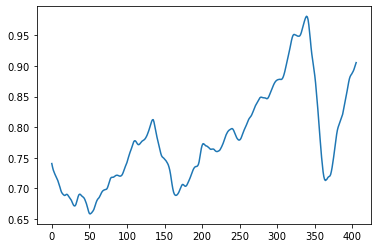

In [90]:
plt.plot(pd)

In [91]:
time_valid   # Last 600 days

array([2900, 2901, 2902, 2903, 2904, 2905, 2906, 2907, 2908, 2909, 2910,
       2911, 2912, 2913, 2914, 2915, 2916, 2917, 2918, 2919, 2920, 2921,
       2922, 2923, 2924, 2925, 2926, 2927, 2928, 2929, 2930, 2931, 2932,
       2933, 2934, 2935, 2936, 2937, 2938, 2939, 2940, 2941, 2942, 2943,
       2944, 2945, 2946, 2947, 2948, 2949, 2950, 2951, 2952, 2953, 2954,
       2955, 2956, 2957, 2958, 2959, 2960, 2961, 2962, 2963, 2964, 2965,
       2966, 2967, 2968, 2969, 2970, 2971, 2972, 2973, 2974, 2975, 2976,
       2977, 2978, 2979, 2980, 2981, 2982, 2983, 2984, 2985, 2986, 2987,
       2988, 2989, 2990, 2991, 2992, 2993, 2994, 2995, 2996, 2997, 2998,
       2999, 3000, 3001, 3002, 3003, 3004, 3005, 3006, 3007, 3008, 3009,
       3010, 3011, 3012, 3013, 3014, 3015, 3016, 3017, 3018, 3019, 3020,
       3021, 3022, 3023, 3024, 3025, 3026, 3027, 3028, 3029, 3030, 3031,
       3032, 3033, 3034, 3035, 3036, 3037, 3038, 3039, 3040, 3041, 3042,
       3043, 3044, 3045, 3046, 3047, 3048, 3049, 30

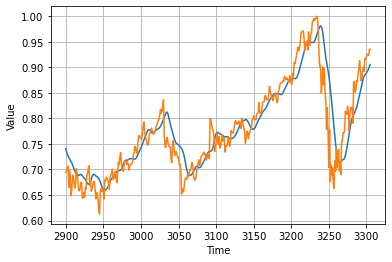

In [92]:
plot_series(time_valid,pd)
plot_series(time_valid, x_valid)

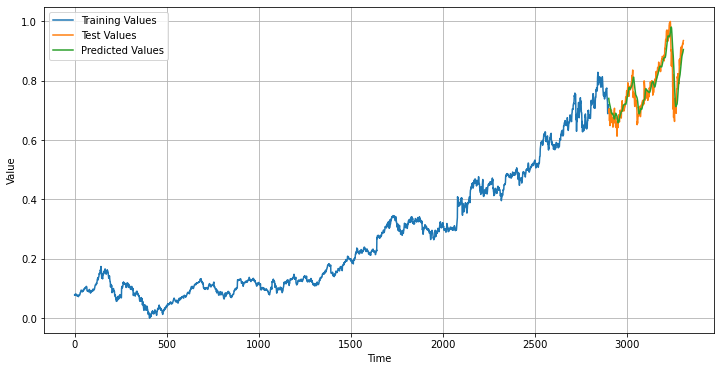

In [93]:
plt.figure(figsize=(12,6))
plot_series(time_train,x_train)
plot_series(time_valid, x_valid)
plot_series(time_valid,pd)
plt.legend(['Training Values','Test Values','Predicted Values'])

In [94]:
rnn_forecast = model_forecast(model, series, window_size)
rnn_forecast = rnn_forecast[split_time - window_size1:-1, -1, 0]

In [95]:
print(rnn_forecast.shape)
print(x_valid.shape)
y=np.array(x_valid)
print(x_valid.shape)

(406,)
(406, 1)
(406, 1)


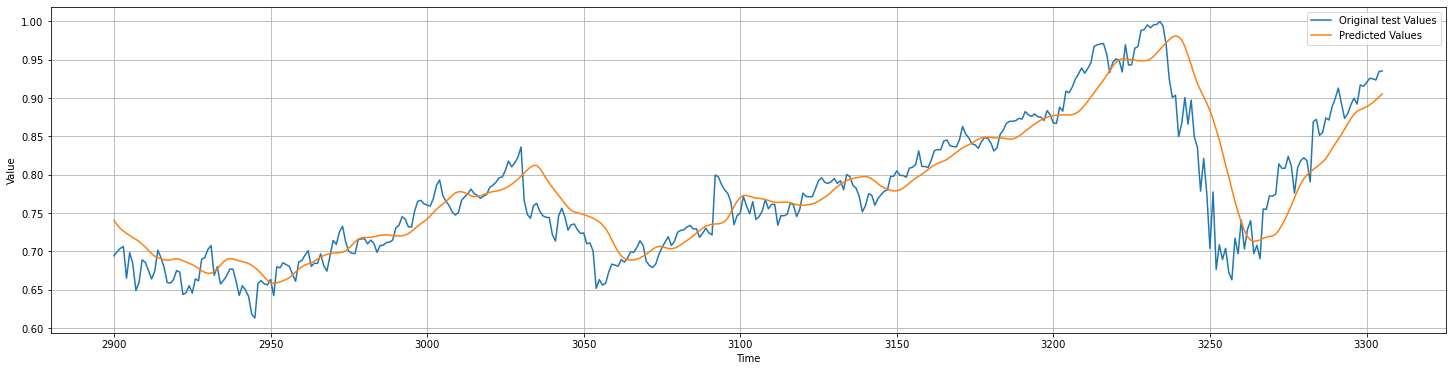

In [96]:
plt.figure(figsize=(25, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)
plt.legend(['Original test Values','Predicted Values'])

In [36]:
#Beyond Future Forecasting :

In [97]:
#Experiment -1 : For Next 64 days :
df_test=web.DataReader('GOOGL',data_source='yahoo',start='05-02-2020',end='07-20-2020')

In [98]:
df_test

High          Low         Open        Close   Volume  \
Date                                                                      
2020-05-01  1351.430054  1309.660034  1324.089966  1317.319946  2443600   
2020-05-04  1324.469971  1296.010010  1308.130005  1322.900024  1540300   
2020-05-05  1371.010010  1335.030029  1337.500000  1349.020020  1983300   
2020-05-06  1368.689941  1345.130005  1358.000000  1345.430054  1586600   
2020-05-07  1376.000000  1352.540039  1361.310059  1369.280029  1532600   
2020-05-08  1396.640015  1372.010010  1381.819946  1384.339966  1666300   
2020-05-11  1415.530029  1375.500000  1376.790039  1403.589966  1633700   
2020-05-12  1414.329956  1374.510010  1408.219971  1375.180054  1695900   
2020-05-13  1385.329956  1328.010010  1376.160034  1348.329956  2018400   
2020-05-14  1357.369995  1323.300049  1333.520020  1356.859985  1833000   
2020-05-15  1374.579956  1339.000000  1348.260010  1373.060059  2077200   
2020-05-18  1392.760010  1354.199951  1361.579956  1385.180054  2356400   
2020-05-19  1392.489990  1373.760010  1385.479980  1374.400024  1579300   
2020-05-20  1412.030029  1387.420044  1389.160034  1409.160034  1913100   
2020-05-21  1416.459961  1394.390015  1410.989990  1406.750000  1544700   
2020-05-22  1417.000000  1395.949951  1403.900024  1413.239990  1427200   
2020-05-26  1445.109985  1419.400024  1441.959961  1421.369995  2229500   
2020-05-27  1425.349976  1394.599976  1420.000000  1420.280029  1584200   
2020-05-28  1444.459961  1399.079956  1400.000000  1418.239990  1758500   
2020-05-29  1436.729980  1415.979980  1420.430054  1433.520020  1852200   
2020-06-01  1441.579956  1422.280029  1425.699951  1434.869995  1258100   
2020-06-02  1443.000000  1421.609985  1435.000000  1442.310059  1172100   
2020-06-03  1449.010010  1431.619995  1442.699951  1439.250000  1386600   
2020-06-04  1441.319946  1406.010010  1436.780029  1414.300049  1349100   
2020-06-05  1446.300049  1407.619995  1415.640015  1440.020020  2132100   
2020-06-08  1449.000000  1424.479980  1426.280029  1448.040039  1693900   
2020-06-09  1467.800049  1442.359985  1445.239990  1452.079956  1681200   
2020-06-10  1472.770020  1454.359985  1461.510010  1464.699951  1588100   
2020-06-11  1451.599976  1398.410034  1441.030029  1401.900024  2357200   
2020-06-12  1434.510010  1385.800049  1425.859985  1412.920044  1832900   
2020-06-15  1425.000000  1387.199951  1389.489990  1420.739990  1523400   
2020-06-16  1457.170044  1428.989990  1449.000000  1446.469971  1532400   
2020-06-17  1462.199951  1435.130005  1452.939941  1452.540039  1528300   
2020-06-18  1452.969971  1426.239990  1449.849976  1434.119995  1743100   
2020-06-19  1444.500000  1419.000000  1440.000000  1424.640015  2639200   
2020-06-22  1450.949951  1419.189941  1425.010010  1450.660034  1472100   
2020-06-23  1475.199951  1445.000000  1452.000000  1463.979980  1887600   
2020-06-24  1475.790039  1430.000000  1463.280029  1432.699951  1579600   
2020-06-25  1442.319946  1419.540039  1431.219971  1441.099976  1197900   
2020-06-26  1437.020020  1355.000000  1432.630005  1362.540039  4882000   
2020-06-29  1398.000000  1351.650024  1360.339966  1397.170044  2253700   
2020-06-30  1424.000000  1386.930054  1396.880005  1418.050049  2014300   
2020-07-01  1448.479980  1414.180054  1419.170044  1442.000000  2109100   
2020-07-02  1488.520020  1451.069946  1451.839966  1469.930054  2860900   
2020-07-06  1510.000000  1476.979980  1488.150024  1499.650024  2235600   
2020-07-07  1521.319946  1489.699951  1496.130005  1489.920044  2118200   
2020-07-08  1511.170044  1492.300049  1500.800049  1503.599976  1588300   
2020-07-09  1529.140015  1495.589966  1509.930054  1518.660034  2091800   
2020-07-10  1541.339966  1500.719971  1513.250000  1539.010010  1795900   
2020-07-13  1576.359985  1506.560059  1549.939941  1512.229980  2147700   
2020-07-14  1522.800049  1485.930054  1492.790039  1520.859985  1905400   
2020-07-15  1536.329956  1497.829956  1523.2

In [100]:
len(df_test)

55

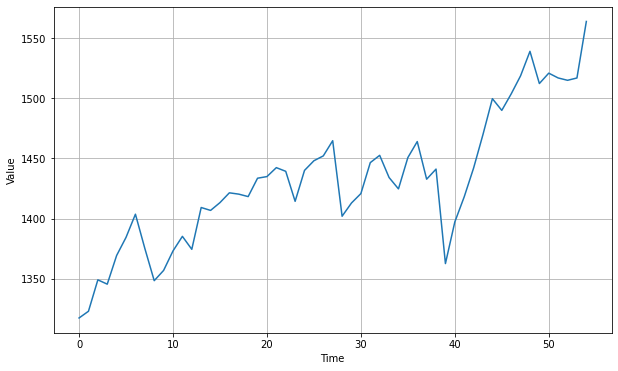

In [101]:
new_time_step=[]
for i in range(df_test.shape[0]):
  new_time_step.append(i)

close_data=df_test['Close']
new_time = np.array(new_time_step)
plt.figure(figsize=(10, 6))
plot_series(new_time,close_data)

In [102]:
x_test=close_data
x_test=np.array(x_test).reshape(-1,1)

In [103]:
scaler1=MinMaxScaler(feature_range=(0,1))
x=scaler1.fit_transform(x_test)
x

array([[0.        ],
       [0.0226354 ],
       [0.12859026],
       [0.11402769],
       [0.21077429],
       [0.27186441],
       [0.34995137],
       [0.23470754],
       [0.12579104],
       [0.16039281],
       [0.22610785],
       [0.2752722 ],
       [0.23154338],
       [0.37254617],
       [0.36276994],
       [0.38909637],
       [0.42207545],
       [0.41765404],
       [0.4093787 ],
       [0.47136161],
       [0.47683774],
       [0.5070181 ],
       [0.49460508],
       [0.39339646],
       [0.49772864],
       [0.53026157],
       [0.54664936],
       [0.59784193],
       [0.34309618],
       [0.38779852],
       [0.41951986],
       [0.52389264],
       [0.54851567],
       [0.47379539],
       [0.43534017],
       [0.54088949],
       [0.5949214 ],
       [0.46803503],
       [0.50210944],
       [0.18343375],
       [0.32390918],
       [0.4086082 ],
       [0.50576036],
       [0.61905766],
       [0.73961571],
       [0.70014637],
       [0.75563855],
       [0.816

In [104]:
len(x)

55

In [109]:
x.dtype

dtype('float64')

(255, 1)

In [329]:
window_size1=20
d=model_forecast(model,x,window_size1)
da=d[len(d)-window_size1:-1,-1,0]
da

array([0.50921935, 0.5131741 , 0.5158986 , 0.5180261 , 0.5262425 ,
       0.53271663, 0.533997  , 0.529024  , 0.50756985, 0.4883296 ,
       0.48302114, 0.49205002, 0.517457  , 0.55072653, 0.5887959 ,
       0.6295614 , 0.6748911 , 0.719184  , 0.7539501 ], dtype=float32)

In [330]:
len(d)

36

In [331]:
len(da)

19

Text(0.5, 1.0, 'prediction for next 19 days')

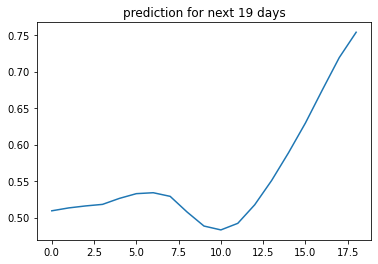

In [333]:
plt.plot(np.arange(0,len(da)),da)
plt.title('prediction for next {} days'.format(len(da)))

In [315]:
window_size=20
batch_size=256
test_val=model_forecast(model,x,window_size)
test_vals=test_val.reshape(-1,1)
test_vals.shape

(720, 1)

In [316]:

results=[]
for i in range(len(test_vals)):
    if(i%(window_size+1)==0):
          results.append(test_vals[i])
len(results)

35

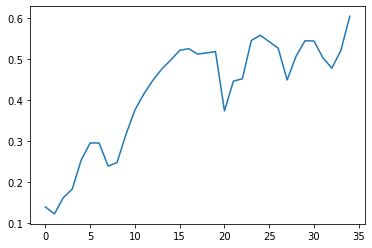

In [317]:
plt.plot(results)

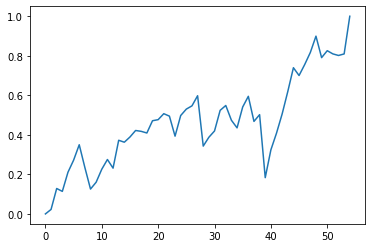

In [318]:
plt.plot(x)

In [319]:
time=np.arange(0,len(df_test))

In [320]:
time

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54])

In [321]:
pred_time=np.arange(len(df_test),len(df_test)+len(results))

In [322]:
pred_time

array([55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
       72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88,
       89])

Text(0.5, 1.0, 'Prediction for next 35 days')

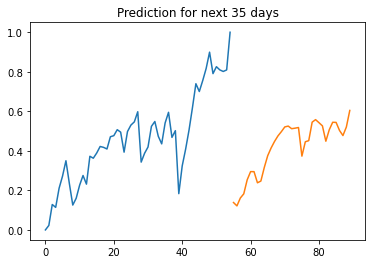

In [324]:
plt.plot(time,x)
plt.plot(pred_time,results)
plt.title('Prediction for next {} days'.format(len(results)))